<a href="https://colab.research.google.com/github/jmoon312/2022carevent/blob/main/CAR_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap # will use this later

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.2 MB/s 


#Step 1: Importing Scripts & Setting up Data

I've set up a sample dataset based on a project I have with Eric Condie, a colleague here at Georgia Tech. In the paper, we're exploring the extent to which social media captures information about the risk of firm failure not captured in an auditor's going concern opinion.

I've anonymized a sample of data that we use in our going concern model, which is what I'll use for this demonstration. The data is available on github, which can be loaded directly into Google Colab.

This block of code will load the data, print descriptive statistics, and define a list (xvars) which contains the predictor variables we'll use in our classifier.

In [ ]:
import pandas as pd, numpy as np
pd.set_option('display.width',150)
pd.set_option('display.max_columns',20)

# Read Dataset
df = pd.read_csv("https://raw.githubusercontent.com/jmoon312/2022carevent/main/GCO_Sample_Data_2022CAR.csv")

# Look at descriptive statistics
print(df.describe().transpose())
# Define x variables
xvars = ['Tenure','FeeRatio','FirmAge','ZScore','Size','Loss','Leverage',
         'ChLeverage','OpCF','Finance','Invest','Returns','Beta','Volatility']

             count      mean       std           min       25%       50%       75%         max
GCO         5000.0  0.010600  0.102419  0.000000e+00  0.000000  0.000000  0.000000    1.000000
Tenure      5000.0  1.904949  0.751237  0.000000e+00  1.386294  2.079442  2.484907    2.890372
Big4        5000.0  0.778600  0.415231  0.000000e+00  1.000000  1.000000  1.000000    1.000000
FeeRatio    5000.0  0.141429  0.138196  0.000000e+00  0.024196  0.104314  0.222111    0.621101
FirmAge     5000.0  2.730144  0.752482  0.000000e+00  2.197225  2.772589  3.218876    4.174387
ZScore      5000.0  2.232858  6.745728 -1.471205e+02  0.484653  1.544287  3.151230  100.537613
Size        5000.0  6.898541  2.108985  1.058137e+00  5.368144  6.890536  8.316711   11.736827
Loss        5000.0  0.483600  0.499781  0.000000e+00  0.000000  0.000000  1.000000    1.000000
Leverage    5000.0  0.584121  0.283002  2.178798e-02  0.384587  0.590995  0.762653    2.729931
ChLeverage  5000.0  0.016008  0.157074 -6.009547e+

# Step 2: Load scikit-learn packages needed to train ML Model
We're going to train a classifier to predict the likelihood a firm uses a Big 4 auditor. This is not what Eric and I do in our paper; we model failure with is a lot harder than whether or not a Big 4 auditor is used! You're welcome to take this same code and try to predict GCOs (also much harder). 

The scikit-learn package includes many different classifiers (Naive Bayes, Random Forests, Boosted ensemble models, etc.). We're going to train a Decision Tree since it's fast.

The code below will split "df" into training and testing datasets. I then do a randaom parameter search to tune the model. I'm using 5-fold cross-validation and 10 different sets of parameters. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# set up some parameters to try #
params = {'criterion':['gini','entropy'],
          'max_depth':[10,50,100,None],
          'random_state':[123],
          'class_weight':[None,'balanced']}

dt = DecisionTreeClassifier() # Leave this as default
train,test = train_test_split(df,train_size=0.80, random_state=123)
# parameters: n_jobs = -1 - parallelize on all cores; cv=5 - 5-fold cross-val;
#             n_iter = 10 - 10 different parameter sets; verbose = 5 - print
#             some output
rs = RandomizedSearchCV(dt,param_distributions=params,n_jobs=-1,cv=5,n_iter=10,
                        verbose=5) 
res = rs.fit(train[xvars],train['Big4'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


#Step 3: Evaluate the model fit
We'll quickly look at how the model performed and then move on to feature importance.

In [ ]:
print("Confusion matrix (Rows = True 0/1, Columns = Predicted 0/1):")
print(confusion_matrix(test['Big4'],rs.predict(test[xvars])))
print("\n\nscikit-learn's classification report, which gives information on accuracy, precision, recall, etc.")
print(classification_report(test['Big4'],rs.predict(test[xvars])))
print("\n\nThe search identified this as the best parameters:")
print(res.best_params_)

Confusion matrix (Rows = True 0/1, Columns = Predicted 0/1):
[[134  92]
 [ 62 712]]


scikit-learn's classification report, which gives information on accuracy, precision, recall, etc.
              precision    recall  f1-score   support

         0.0       0.68      0.59      0.64       226
         1.0       0.89      0.92      0.90       774

    accuracy                           0.85      1000
   macro avg       0.78      0.76      0.77      1000
weighted avg       0.84      0.85      0.84      1000



The search identified this as the best parameters:
{'random_state': 123, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}


# Step 4: Permutation Importance
I'll illustrate two approaches to evaluating feature importance. The first, referred to as permutation importance, randomly shuffles each feature and evaluates how much model performance is impacted. 

Here's an example of implementation, which is largely based on the [scikit-learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html). For a custom implementation, [see here](https://github.com/azsom/ODSC-East-2022/blob/main/interpretability_in_ML.ipynb).

In [ ]:
from sklearn.inspection import permutation_importance
metrics = ['balanced_accuracy','precision_macro','recall_macro']
r = permutation_importance(rs, test[xvars], test['Big4'],n_repeats=30,
                           random_state=123,scoring=metrics)

# r is dictionary with an entry for each metric. Each value (of the dictionary 
# Contains three items: mean importance (by feature), 
# standard deviation of importance (by feature), and the individual deviations

# This loop will print each feature provided it is "significant", based on it 
# being more than 2 standard deviations above 0:
print("\n\n----------------------------------------------------------------------")
print("Here are the significant features, in order of importance, by metric:")
for metric in r:
    print(f"{metric}")
    rm = r[metric]
    for i in rm.importances_mean.argsort()[::-1]:
        if rm.importances_mean[i] - 2 * rm.importances_std[i] > 0:
            print(f"    {xvars[i]:<8}"
                  f"{rm.importances_mean[i]:.3f}"
                  f" +/- {rm.importances_std[i]:.3f}")
            
print("----------------------------------------------------------------------")

print("\n\n----------------------------------------------------------------------")
print("Here are the features that are not significant, still ordered by importance.")
for metric in r:
    print(f"{metric}")
    rm = r[metric]
    for i in rm.importances_mean.argsort()[::-1]:
        if rm.importances_mean[i] - 2 * rm.importances_std[i] <= 0:
            print(f"    {xvars[i]:<8}"
                  f"{rm.importances_mean[i]:.3f}"
                  f" +/- {rm.importances_std[i]:.3f}")            
print("----------------------------------------------------------------------")



----------------------------------------------------------------------
Here are the significant features, in order of importance, by metric:
balanced_accuracy
    Size    0.137 +/- 0.017
    Tenure  0.100 +/- 0.012
    FirmAge 0.042 +/- 0.014
    ZScore  0.038 +/- 0.007
    Invest  0.019 +/- 0.010
    Beta    0.018 +/- 0.006
precision_macro
    Size    0.159 +/- 0.017
    Tenure  0.105 +/- 0.013
    FirmAge 0.071 +/- 0.012
    Beta    0.034 +/- 0.007
    Invest  0.031 +/- 0.008
    ZScore  0.030 +/- 0.009
    Volatility0.012 +/- 0.005
recall_macro
    Size    0.137 +/- 0.017
    Tenure  0.100 +/- 0.012
    FirmAge 0.042 +/- 0.014
    ZScore  0.038 +/- 0.007
    Invest  0.019 +/- 0.010
    Beta    0.018 +/- 0.006
----------------------------------------------------------------------


----------------------------------------------------------------------
Here are the features that are not significant, still ordered by importance.
balanced_accuracy
    Leverage0.008 +/- 0.005
    FeeRa

You can see subtle differences by metric, but for the most part each suggests Size, Tenure, and Firm Age are most important. 

Plotting these values can also be informative and easier to process. We'll limit this to balanced accuracy ([credit for this approach](https://github.com/azsom/ODSC-East-2022/blob/main/interpretability_in_ML.ipynb)).

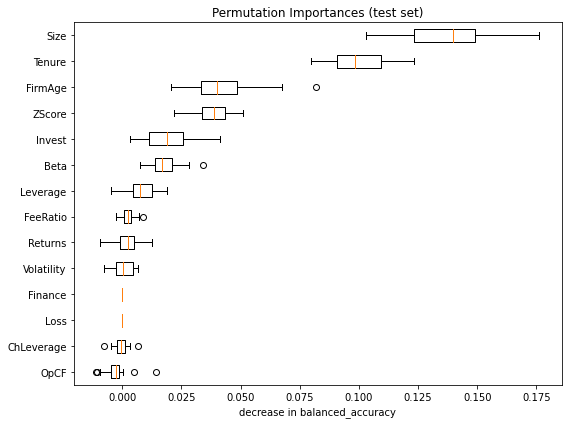

In [7]:
import matplotlib.pyplot as plt
metric = 'balanced_accuracy'
impts = r[metric]
sorted_indcs = impts.importances_mean.argsort()
plt.figure(figsize=(8,6))
plt.boxplot(impts.importances[sorted_indcs].T,labels=np.array(xvars)[sorted_indcs],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel(f'decrease in {metric}')
plt.tight_layout()
plt.show()

# Step 5: Evaluating Feature Importance with SHAP (SHapley Additive exPlanations) Values
One significant limitation to the previous analysis is that features are correlated, so permutating a feature doesn't necessarily remove its influence from the model. Note that volatility appears insignificant to the model based on the analysis above, but consider correlations between volatility and the other features:


In [8]:
print(train[xvars].corr()['Volatility']) 

Tenure       -0.211315
FeeRatio     -0.119777
FirmAge      -0.250424
ZScore       -0.079311
Size         -0.514598
Loss          0.401514
Leverage     -0.096944
ChLeverage   -0.004747
OpCF         -0.371686
Finance      -0.090105
Invest        0.035207
Returns      -0.029757
Beta          0.174837
Volatility    1.000000
Name: Volatility, dtype: float64


Volatility is significantly associated with Size, which is highly important. So if Size were excluded from the model, would volatility be important? If one is purely focused on which variables drive model performance, this correlation issue may not be that important, but it's hard to conclude that volatility "doesn't matter" from this analysis alone.

SHAP values don't fully alleviate this issue, but they do provide more insight into when features may or may not matter. The estimates are based on a cooperative game equilibrium. In essence, in a cooperative game there exists an equilibrium where the outcome is the weighted contributions of each player, with some players adding more or less to a given outcome. This same logic is applied to a trained model, and each prediction is expressed as the sum of individual feature importances.

Credit for my (developing) understanding of the intuition behind and how to use SHAP values comes from [this illustration](https://github.com/azsom/ODSC-East-2022/blob/main/interpretability_in_ML.ipynb), which was developed by Professor Andras Zsom (Brown University). There are a few different Python implementations--I'm using the shap package, consistent with the link above.

The specific example I provide below was adapted for the Decision Tree model we use, and is based on [this post](https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b).

Below, I first review attributes of the original data and then the structure of what the shap package provides. 

In [9]:
import shap
print(type(rs.best_estimator_)) # need to extract the estimator to use with shap (the RandomizedSearchCV object is not supported)
mod = rs.best_estimator_ # This is the DecisionTree classifier
exp = shap.TreeExplainer(mod,data=None,model_output='raw',feature_names=xvars,
                         feature_perturbation='tree_path_dependent') # sets up "explainer" using the trained model
shap_values = exp.shap_values(test[xvars]) # extracts SHAP values for the holdout (test) sample
print(f'Shape of test data: {test[xvars].shape}') # simply the shape of the input matrix
print(f'Type of shap values: {type(shap_values)}. Length of the list: {len(shap_values)}.') # two classes
print(f'Shape of shap_values: {np.array(shap_values).shape}') # two elements, each with shape matching data matrix

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Shape of test data: (1000, 14)
Type of shap values: <class 'list'>. Length of the list: 2.
Shape of shap_values: (2, 1000, 14)


With SHAP values, you can examine the influence for individual observations. This could be useful if you had some mechanism to partition observations. For instance, how important is size for firms in industry X?

Example:

In [10]:
shap.initjs()
print(f"Recall the mean of Big4 is {train['Big4'].mean()}, which is the 'base value'")
print("Looking at Row 0:")
print(test.iloc[0])
print("Here are the feature importances for this prediction:")
shap.force_plot(exp.expected_value[1], shap_values[1][0], features=test[xvars].iloc[0,:])

Recall the mean of Big4 is 0.77975, which is the 'base value'
Looking at Row 0:
GCO           0.000000
Tenure        2.079442
Big4          0.000000
FeeRatio      0.000000
FirmAge       2.772589
ZScore       -6.689108
Size          3.425858
Loss          1.000000
Leverage      0.597808
ChLeverage    0.018572
OpCF          0.050408
Finance       1.000000
Invest        0.435526
Returns       0.354556
Beta          1.519304
Volatility    0.041822
Name: 2648, dtype: float64
Here are the feature importances for this prediction:


You can also examine summary plots:

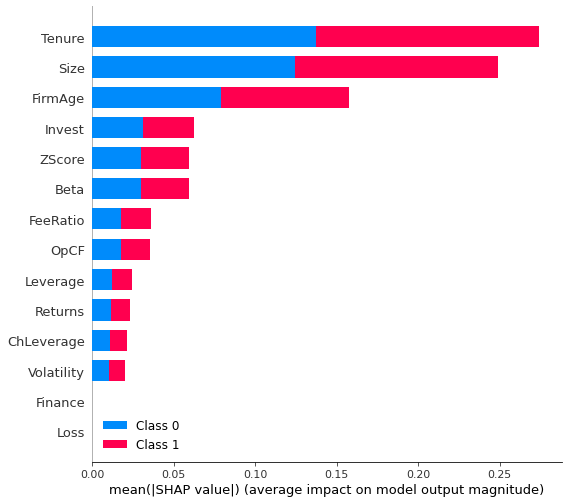

In [11]:
shap.summary_plot(shap_values,features=test[xvars])

With two classes the color coding isn't relevant (they are exact inverses), but if you were predicting multiple classes it would be useful. Here's the same plot where we only predict Big4 (Class 1). Notice how these are slightly different than the permutation-based rankings.

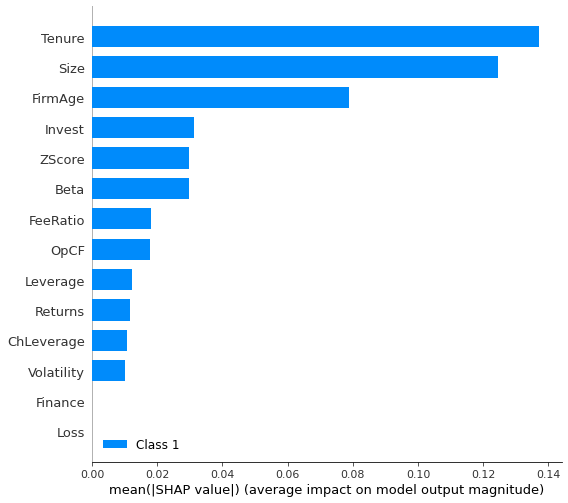

In [12]:
shap.summary_plot(shap_values,features=test[xvars],class_inds=[1])

The last plot we'll generate combines some of the earlier information, plotting the distribution of importances by feature:

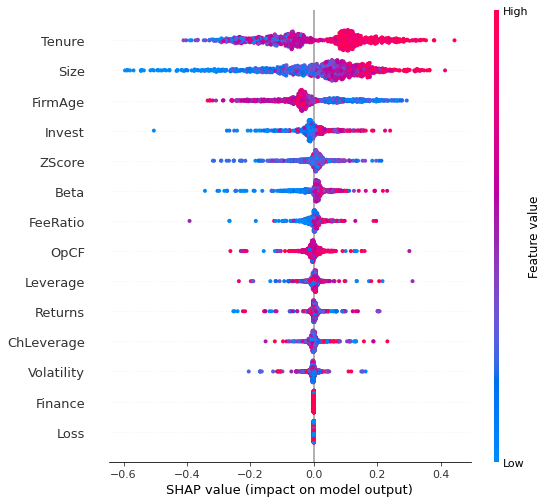

In [13]:
shap.summary_plot(shap_values[1],features=test[xvars])